## **Imports**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import plotly.express as px

In [3]:
data = pd.read_csv('/content/combine_rating_all_vehicle.csv')
data.head()

,Rating,Model Name,Type
0,1.0,TVS iQube,2-wheeler
1,1.0,TVS iQube,2-wheeler
2,3.0,TVS iQube,2-wheeler
3,1.0,TVS iQube,2-wheeler
4,1.0,TVS iQube,2-wheeler


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1113 entries, 0 to 1112
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Rating      1113 non-null   float64
 1   Model Name  1113 non-null   object 
 2   Type        1113 non-null   object 
dtypes: float64(1), object(2)
memory usage: 26.2+ KB


## **Pre Processing**

In [5]:
col = 'Model Name'
modelCounts = pd.DataFrame(data[col].value_counts())
modelCounts.reset_index(inplace=True)
modelCounts.columns = ['Model Name', 'Count']
modelCounts.head()

,Model Name,Count
0,Hero Electric Flash,102
1,Okinawa Praise,95
2,Hero Electric Optima,82
3,tata nexon ev,75
4,Tata Nexon EV,74


In [6]:
temp = modelCounts.sort_values(by=['Model Name']).reset_index()
temp = temp[list(temp.columns[1:])]
temp.head()

,Model Name,Count
0,Ampere Magnus EX,28
1,Ampere Magnus Pro,22
2,Ampere REO,24
3,Ampere Zeal,13
4,Ather 450X,30


In [7]:
modelRating = pd.DataFrame(data.groupby(['Model Name', 'Type']).mean()).reset_index()
modelRating.head()

,Model Name,Type,Rating
0,Ampere Magnus EX,2-wheeler,3.964286
1,Ampere Magnus Pro,2-wheeler,3.090909
2,Ampere REO,2-wheeler,2.583333
3,Ampere Zeal,2-wheeler,2.846154
4,Ather 450X,2-wheeler,3.666667


In [8]:
df = pd.concat([modelRating, temp], axis=1)
df = df.T.drop_duplicates().T

df['NewType'] = df['Type'].apply(lambda x: x.split('-')[0])
df.drop_duplicates(keep='first', inplace=True)
df.head()

,Model Name,Type,Rating,Count,NewType
0,Ampere Magnus EX,2-wheeler,3.964286,28,2
1,Ampere Magnus Pro,2-wheeler,3.090909,22,2
2,Ampere REO,2-wheeler,2.583333,24,2
3,Ampere Zeal,2-wheeler,2.846154,13,2
4,Ather 450X,2-wheeler,3.666667,30,2


## **EDA**

In [9]:
fig = px.bar(df.sort_values(by=['Count']), x = 'Model Name', y='Count', title='Count of Vehicles Sold VS Model')
fig.show()

In [10]:
fig = px.bar(df.sort_values(by=['Rating']), x="Model Name", y="Rating", color='Type', barmode='group', title='Avg. Rating of Vehicles Sold VS Type')
fig.show()

In [11]:
fig = px.bar(pd.DataFrame(df['Type'].value_counts()), title='Count of Vehicles Sold VS Type')
fig.show()

In [12]:
fig = px.box(df, x='Type', y = 'Rating', title='BoxPlot of Ratings')
fig.show()

In [13]:
fig = px.histogram(df, x = 'Rating', title='BoxPlot of Ratings')
fig.show()

## **Resampling for Clustering**

In [14]:
from sklearn.utils import resample

wheels_2 = df[df['NewType'] == '2']
wheels_4 = df[df['NewType'] == '4']

wheels_2_downsample = resample(wheels_2,
             replace=True,
             n_samples=len(wheels_4),
             random_state=np.random.randint(1, 101))

print(wheels_2_downsample.shape)
print(wheels_4.shape)

(8, 5)
(8, 5)


In [15]:
D = pd.concat([wheels_2_downsample, wheels_4], axis=0).reset_index()
D = D[list(D)[1:]]
# D.drop_duplicates(keep='first', inplace=True)
D

,Model Name,Type,Rating,Count,NewType
0,Hero Electric Flash,2-wheeler,3.862745,102,2
1,Odysse Evoqis,2-wheeler,5.0,3,2
2,Hero Electric NYX HX,2-wheeler,5.0,2,2
3,Ampere Magnus EX,2-wheeler,3.964286,28,2
4,Revolt RV 300,2-wheeler,4.2,10,2
5,Ampere Zeal,2-wheeler,2.846154,13,2
6,Ampere Magnus EX,2-wheeler,3.964286,28,2
7,Joy e-bike Monster,2-wheeler,3.0,2,2
8,BYD E6,4-wheeler,4.5,5,4
9,Kia EV6,4-wheeler,4.583333,12,4


## **Clustering**

In [16]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [17]:
X = D[['NewType', 'Rating', 'Count']]
X.head()

,NewType,Rating,Count
0,2,3.862745,102
1,2,5.0,3
2,2,5.0,2
3,2,3.964286,28
4,2,4.2,10


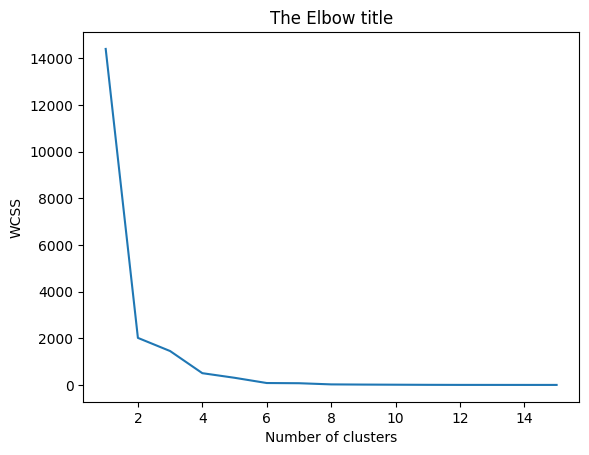

In [18]:
wcss=[]
r = range(1, 16)
for i in r:
  kmeans = KMeans(i, n_init=1)
  kmeans.fit(X)
  wcss_iter = kmeans.inertia_
  wcss.append(wcss_iter)

number_clusters = r
plt.plot(number_clusters,wcss)
plt.title('The Elbow title')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

### **Made 2 Clusters**

In [19]:
kmeans = KMeans(n_clusters=2, random_state=np.random.randint(1, 11), n_init="auto").fit(X)

In [20]:
data_with_clusters = D.copy()
identified_clusters = kmeans.fit_predict(X)
data_with_clusters['Clusters'] = identified_clusters

In [21]:
y = 'Count'
fig = px.bar(data_with_clusters.sort_values(by = [y]), x = 'Model Name', y = y, color = 'Clusters', barmode = 'group')
fig.show()

In [22]:
y = 'Rating'
fig = px.bar(data_with_clusters.sort_values(by = [y]), x = 'Model Name', y = y, color = 'Clusters', barmode = 'group')
fig.show()

### **Made 3 Clusters**

In [23]:
kmeans = KMeans(n_clusters=3, random_state=np.random.randint(1, 11), n_init="auto").fit(X)

In [24]:
data_with_clusters = D.copy()
identified_clusters = kmeans.fit_predict(X)
data_with_clusters['Clusters'] = identified_clusters

In [25]:
y = 'Count'
fig = px.bar(data_with_clusters.sort_values(by = [y]), x = 'Model Name', y = y, color = 'Clusters', barmode = 'group')
fig.show()

In [26]:
y = 'Rating'
fig = px.bar(data_with_clusters.sort_values(by = [y]), x = 'Model Name', y = y, color = 'Clusters', barmode = 'group')
fig.show()

## **Conclusion: It works well with Count of Vehicle sold, not Rating**